In [1]:
from agilentpyvisa.reram_helpers_B1500 import *

# display images in the notebook %matplotlib notebook makes them interactive!
%matplotlib inline

import os
import os.path
today=datetime.today().strftime("%Y-%m-%d")
already_in = today in os.path.abspath(".")
if not already_in and not os.path.exists(today):
    os.mkdir(today)
if not already_in:
    os.chdir(today)
print(os.path.abspath("."))


SyntaxError: invalid syntax (__init__.py, line 14)

To make creating your own measuring script easier, here are some starting helper functions and definitions.

With the setup functions, we define some basic procedures, which make up the vocabulary for our test

We can then also build more complex testing procedures from these building blocks

And even more complex tests with automated logging, estimation when we are done and some basic SI unit handling

# Sample tests

Below is how I used the setup above when testing, together with the results

                 EI            ET          EV  cumulative_energy
count  2.000000e+02    200.000000  200.000000         200.000000
mean   1.503169e-04  68219.291050    1.500000           0.000121
std    4.576286e-05      0.275408    0.876928           0.000089
min    9.500000e-09  68218.780000    0.000000           0.000000
25%    1.622750e-04  68219.060000    0.749937           0.000030
50%    1.723000e-04  68219.290000    1.500000           0.000120
75%    1.737375e-04  68219.522500    2.250063           0.000212
max    1.750500e-04  68219.770000    3.000000           0.000240


4123.348692046334

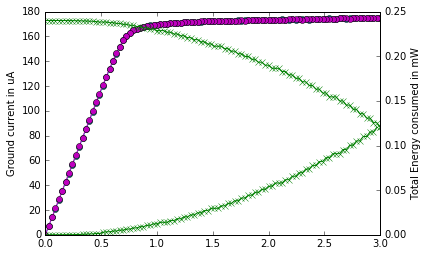

In [87]:
form_sweep= plt.figure(figsize=[10,5])
f=form(3,100,10e-3, mrange=MeasureRanges_I.uA10_limited,gate=1.9)
f=add_energy(f)
f.to_csv("{}_form_3V.csv".format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
plt.autoscale()
checkR()

31778.409090909096
                 EI            ET          EV  cumulative_energy
count  2.000000e+02    200.000000  200.000000         200.000000
mean  -1.521310e-05  67571.562550   -0.750000           0.000008
std    1.353450e-05      0.303423    0.438458           0.000007
min   -7.707500e-05  67571.010000   -1.500000          -0.000000
25%   -2.145375e-05  67571.310000   -1.125000           0.000001
50%   -1.249500e-05  67571.575000   -0.750000           0.000009
75%   -6.313875e-06  67571.810000   -0.375000           0.000015
max    1.000000e-09  67572.080000    0.000000           0.000016
38021.08433734939


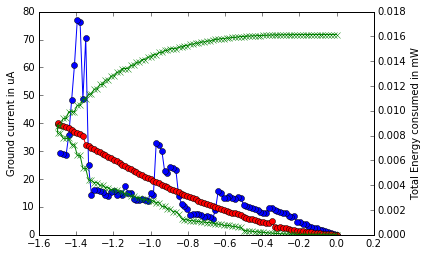

In [84]:
print(checkR())
reset_sweep(-1.5,100,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=SMU3,plot=True)
print(checkR())

Reset with Peak -1.5V, 100 steps, gate 1.9V
               EI            ET          EV  cumulative_energy
count  200.000000    200.000000  200.000000         200.000000
mean    -0.000064  68223.094050   -0.750000           0.000035
std      0.000076      0.287616    0.438458           0.000021
min     -0.000230  68222.570000   -1.500000          -0.000000
25%     -0.000121  68222.857500   -1.125000           0.000013
50%     -0.000023  68223.095000   -0.750000           0.000048
75%     -0.000007  68223.332500   -0.375000           0.000052
max      0.000000  68223.600000    0.000000           0.000053
HRS 33068.273092369476
Set with Peak 1.5V, 100 steps, gate 1.9V
                 EI           ET          EV  cumulative_energy
count  2.000000e+02    200.00000  200.000000         200.000000
mean   9.353574e-05  68227.16030    0.750000           0.000044
std    6.996351e-05      0.28656    0.438458           0.000037
min   -3.500000e-09  68226.64000    0.000000          -0.000000
25%  

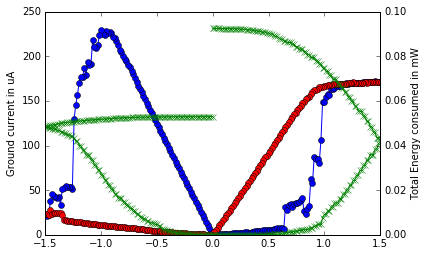

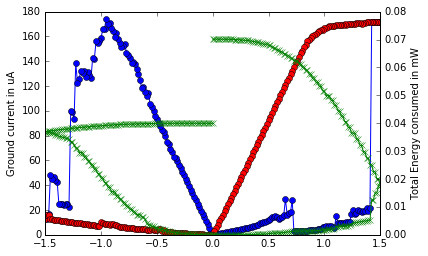

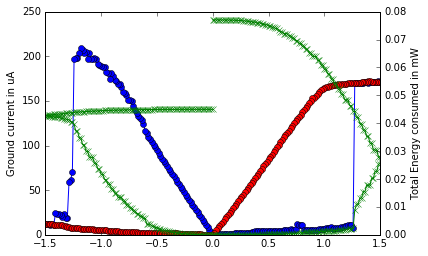

In [88]:
perc = np.ones(3)
iters= len(perc) 
pinches=[]
sleep_between=1
for i in range(iters):
    fig,ax1 = plt.subplots()
    ax2=ax1.twinx()
    #plt.suptitle("Reset gate 1.9V, Set gate {}V".format(perc[i]*1.9))
    plt.hold(True)
    rgate = 1.9
    rpeak=-1.5
    rsteps=100
    print('Reset with Peak {}V, {} steps, gate {}V'.format(rpeak, rsteps, rgate))
    rt=reset_sweep(rpeak, rsteps,5e-3, mrange=MeasureRanges_I.uA10_limited,gate=rgate,plot=False)
    rt=add_energy(rt)
    rt.to_csv("{}_reset_gate{}_-1_5V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),rgate)
             )
    plot_output(rt,fig=fig,ax1=ax1,ax2=ax2)
    
    print('HRS',checkR())
    time.sleep(sleep_between)
    speak= 1.5
    ssteps= 100
    sgate= 1.9 * perc[i]
    print('Set with Peak {}V, {} steps, gate {}V'.format(speak, ssteps, sgate))
    s=set_sweep(speak,ssteps,10e-3, mrange=MeasureRanges_I.uA10_limited,gate=sgate,plot=False)
    s=add_energy(s)
    s.to_csv("{}_set_gate{}_1V.csv".format(
            datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),sgate)
            )
    plot_output(s,fig=fig,ax1=ax1,ax2=ax2)
    
    print('LRS',checkR())
    time.sleep(sleep_between)
    #plt.yscale("log")
    pinches.append((rt,s,rgate,sgate))

frames=[]
for rt,s,rgate,sgate in pinches:
    rt['gateV']=[rgate]*len(rt.index)
    rt['type']='reset'
    s['gateV']=[sgate]*len(s.index)
    s['type']='set'
    frames.append(rt)
    frames.append(s)
frames = pd.concat(frames)
frames.to_csv('{}_pinchrun.csv'.format(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

In [183]:
import scipy.stats as stat
from sklearn.naive_bayes import GaussianNB

stat.normaltest(rdf.iloc[rdf[rdf['Type']=='Set'].index[0:-1]+1]['Resistance'].values)

NormaltestResult(statistic=0.42627940789849994, pvalue=0.80804324249861126)

In [ ]:
res_state=GaussianNB()
#lrsmean=1820, std=22
#res_state.fit(data,labels)
def is_lrs(datum):
    sp.s
def is_hrs(datum):
    

In [243]:
search=[]

1414.15996622
1417.27248566
1464.73235268
1422.30407115
1473.41126125


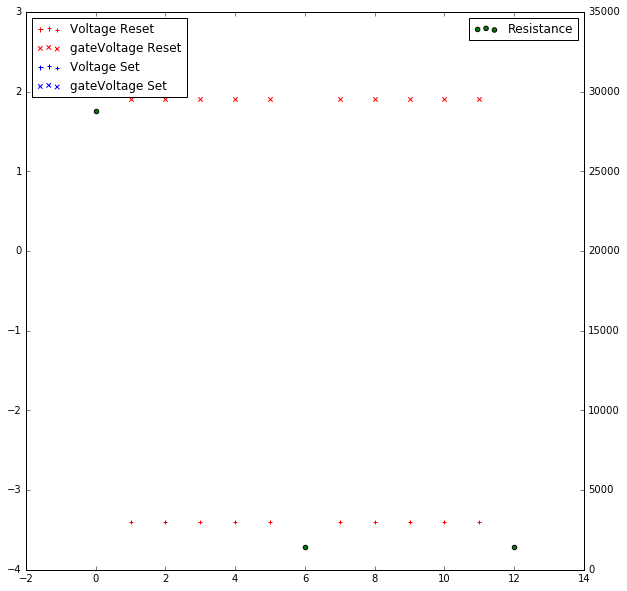

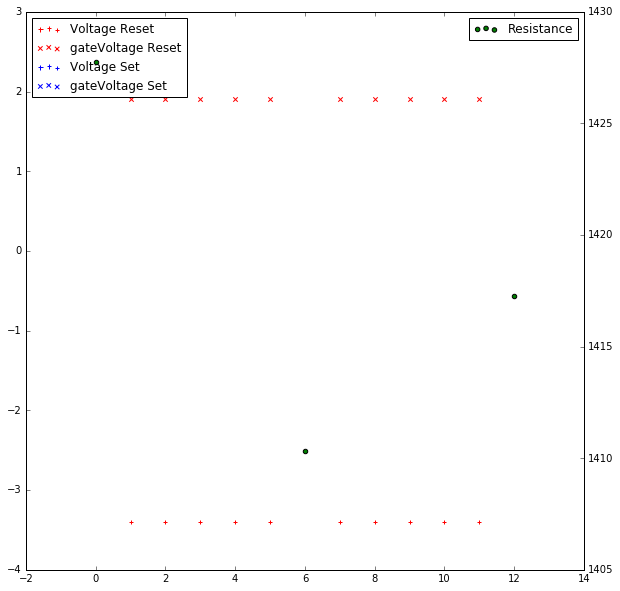

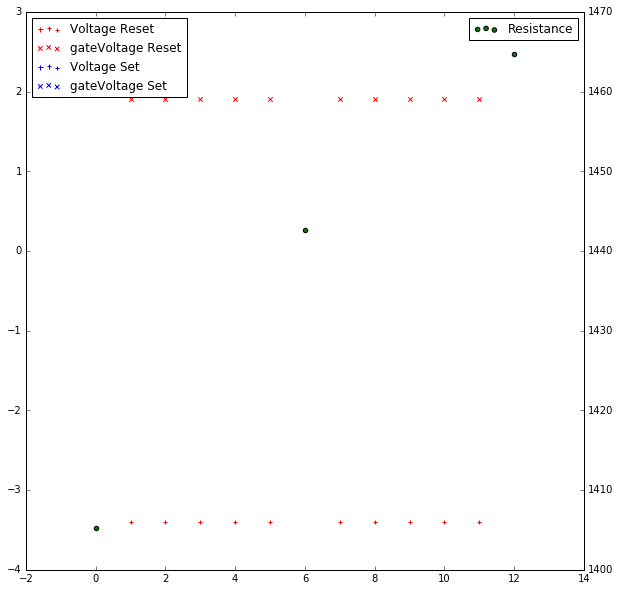

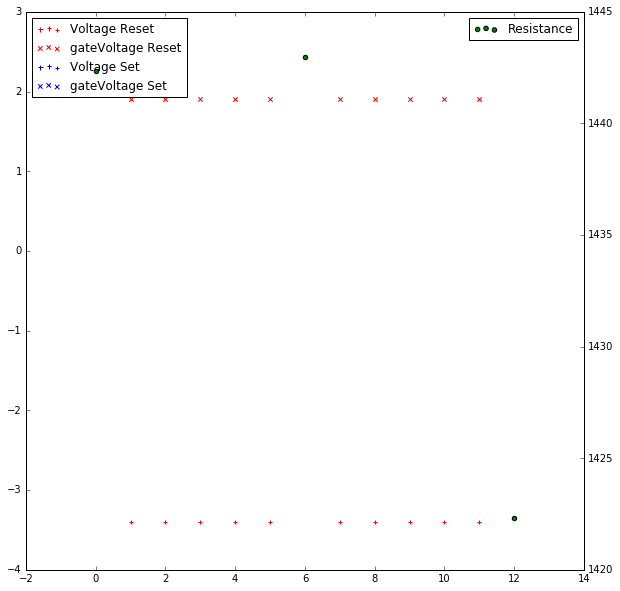

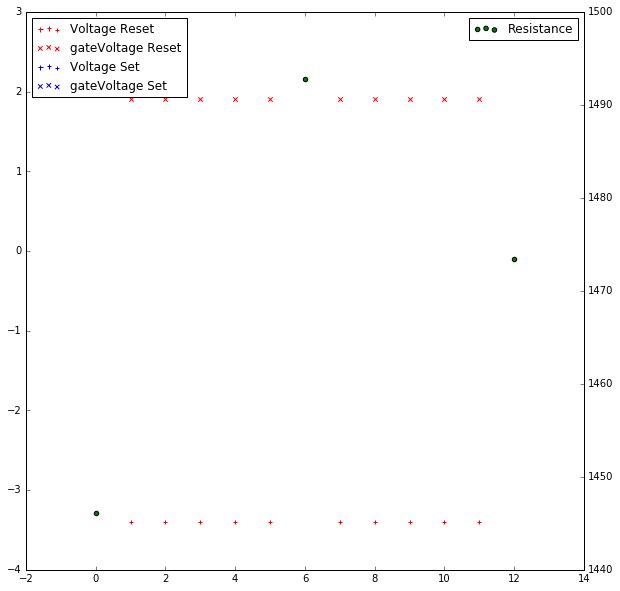

In [279]:

for i in range(5):
    find_hrs=get_series(10,-3.4,width=500e-6,slope=.2,count=100)
    find_hrs=insert_read_every(find_hrs,5)
    find_out=consume_patterns(find_hrs)
    fhr =parse_job_results(find_out)
    search.append(fhr)
    plot_pattern_results(fhr)
    print(fhr.iloc[-1]['Resistance'])
    if fhr.iloc[-1]['Resistance']>12e3:
        break

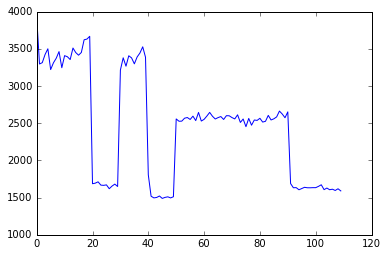

In [263]:
res_found=pd.concat(search)['Resistance'].dropna()
plt.plot(range(len(res_found)),res_found.values)

In [252]:
get_series(5,-1,width=1000e-6)

[pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9),
 pattern_pulse(voltage=-8.4, width=0.001, slope=0.2, gate=4, gateVoltage=1.9)]